# Data Preparation & Exploration 

In [129]:
#Loading libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
%pylab inline
from datetime import datetime
import pickle 
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
import category_encoders as ce
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
import shap

pd.set_option('display.max_rows', 500)

Populating the interactive namespace from numpy and matplotlib


pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy


In [130]:
import sklearn
sklearn.__version__

'0.21.3'

In [131]:
TODO = 100000
train = pd.read_pickle("train_set.pickle").sample(n=TODO)
train.loc[:,"clicked"] = train.loc[:,"clicked"].map({True:1, False:0})



In [132]:

#TODO replace with Ayelet code
train.loc[:,'time'] = pd.to_datetime(train['timestamp'], unit='s')
train.loc[:,'Day_of_Week'] = train['time'].dt.weekday_name

# note monday == 0 
train.loc[:,'weekend'] = train['time'].dt.dayofweek > 4

train.loc[:,'Month'] = train['time'].dt.month_name().str[:3]
train.loc[:,'hour'] = train['time'].dt.hour

train.loc[:,'device_diag'] = np.sqrt(train.device_height^2 + train.device_width^2).round()
train.loc[:,'manufacturer'] = train['manufacturer'].fillna('Unknown')

In [133]:
train_df, other = train_test_split(train, test_size=0.2, random_state=42)
dev_val, dev_test = train_test_split(other, test_size=0.5, random_state=42)

In [134]:
train_df.shape, dev_val.shape, dev_test.shape

((80000, 18), (10000, 18), (10000, 18))

In [135]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000 entries, 1793057 to 1813110
Data columns (total 18 columns):
timestamp         80000 non-null int64
state             80000 non-null object
user_isp          80000 non-null object
app_id            80000 non-null object
app_cat           80000 non-null object
banner_pos        80000 non-null object
manufacturer      80000 non-null object
device_model      55600 non-null object
device_version    80000 non-null object
device_height     80000 non-null int64
device_width      80000 non-null int64
clicked           80000 non-null int64
time              80000 non-null datetime64[ns]
Day_of_Week       80000 non-null object
weekend           80000 non-null bool
Month             80000 non-null object
hour              80000 non-null int64
device_diag       80000 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(1), int64(5), object(10)
memory usage: 11.1+ MB


In [136]:
# TODO update features list
features = ['app_cat', 'banner_pos', 'device_diag', 'state' , 'Day_of_Week', 'Month', 'hour' , 'device_version' , 'manufacturer']
cat_features = ['app_cat','banner_pos','state' ,  'Day_of_Week', 'Month', 'hour','device_version' , 'manufacturer']

In [137]:
X_train = train_df[features]
y_train = train_df['clicked']
X_val = dev_val[features]
y_val = dev_val['clicked']


In [138]:
def make_rf_pipe_line(calibration = None, class_weight = None):
    assert calibration is None or calibration in ['isotonic', 'sigmoid']
    encoder = ce.TargetEncoder(cols=cat_features)
    rf = RandomForestClassifier(n_estimators = 200, max_depth=5, criterion = "gini", n_jobs = 4,
                                min_samples_split=100, class_weight = class_weight,random_state=13)
    if calibration is None:
        rf_pipe = Pipeline([('target_enc',encoder),  ('classifier', rf)])
    else:
        calibrated_RF_classifier =  CalibratedClassifierCV(base_estimator=rf, cv=5, method=calibration)
        rf_pipe = Pipeline([('target_enc',encoder),  ('calibrated_classifier', calibrated_RF_classifier)])
    rf_pipe.fit(X_train, y_train)
    return rf_pipe


In [139]:
def plot_auc(fpr, tpr):
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.3f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()

In [140]:

def plot_calibration(y, y_hat):
    # reliability diagram
    fop, mpv = calibration_curve(y, y_hat, n_bins=10, normalize=True)
    # plot perfectly calibrated
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot model reliability
    pyplot.plot(mpv, fop, marker='.')
    plt.xlabel("Mean predicted probabilities")
    plt.ylabel("True Probabilities")
    plt.title("Calibration Curve")
    pyplot.show()

In [141]:
def find_threshold(y, y_hat):
    num_actual_clicks = sum(y)
    threshold = 0.5
    num_predicted_clicks = sum(y[y_hat>=threshold])
    while num_predicted_clicks < num_actual_clicks:
        threshold = threshold - 0.01
        num_predicted_clicks = sum(y[y_hat>=threshold])
        #print (f"""threshold:{threshold}, num_predicted_clicks:{num_predicted_clicks}""")
    
    return threshold

In [142]:
def evaulate_pipeline(pipe, X, y):
    y_hat = pipe.predict_proba(X)[:,1]
    assert y.shape ==  y_hat.shape
    fpr, tpr, thresholds = metrics.roc_curve(y, y_hat, pos_label=1)
    plot_auc(fpr, tpr)
    plot_calibration(y, y_hat)
    #plt.hist(y_hat[y_hat >= 0], bins=10, density=False)
    plt.hist(y_hat, bins=100, density=True)
    plt.title("Histogram of predicted probabilities for click")
    threshold = find_threshold(y, y_hat)
    print (f"""threshold={threshold:.2f}, num clicks: predicted={sum(y[y_hat>=threshold])}, actual={sum(y)}""")
    

# Random Forest PipeLine

Pipeline(memory=None,
         steps=[('target_enc',
                 TargetEncoder(cols=['app_cat', 'banner_pos', 'state',
                                     'Day_of_Week', 'Month', 'hour',
                                     'device_version', 'manufacturer'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', min_samples_leaf=1,
                               return_df=True, smoothing=1.0, verbose=0)),
                ('classifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=5,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1,
                 

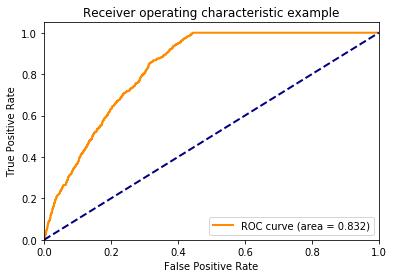

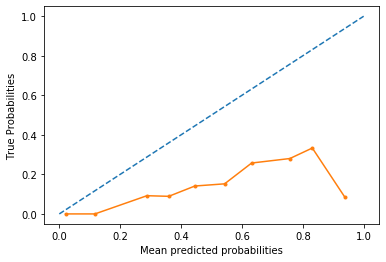

threshold=0.08, num clicks: predicted=631, actual=631


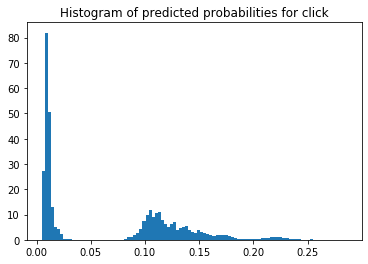

In [143]:
rf_pipe = make_rf_pipe_line(None)
print (rf_pipe)
evaulate_pipeline(rf_pipe, X_val, y_val)

Pipeline(memory=None,
         steps=[('target_enc',
                 TargetEncoder(cols=['app_cat', 'banner_pos', 'state',
                                     'Day_of_Week', 'Month', 'hour',
                                     'device_version', 'manufacturer'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', min_samples_leaf=1,
                               return_df=True, smoothing=1.0, verbose=0)),
                ('calibrated_classifier',
                 CalibratedClassifierCV(base_estimator=Rando...r(bootstrap=True,
                                                                              class_weight=None,
                                                                              criterion='gini',
                                                                              max_depth=5,
                                                                              max_features='auto',
  

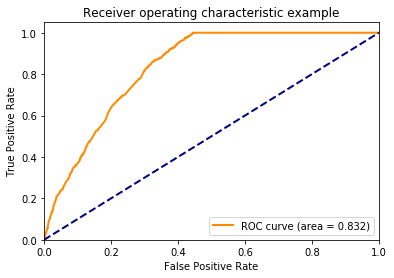

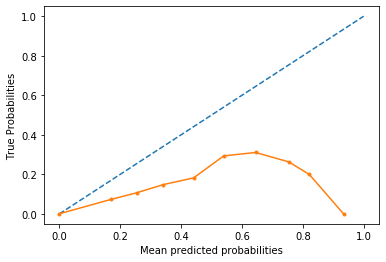

threshold=-0.00, num clicks: predicted=631, actual=631


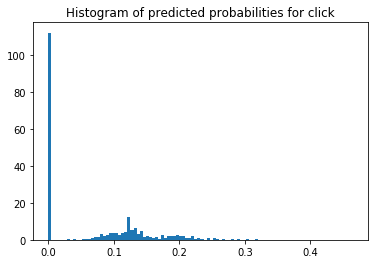

In [144]:
rf_pipe = make_rf_pipe_line(calibration = 'isotonic')
print (rf_pipe)
evaulate_pipeline(rf_pipe, X_val, y_val)

Pipeline(memory=None,
         steps=[('target_enc',
                 TargetEncoder(cols=['app_cat', 'banner_pos', 'state',
                                     'Day_of_Week', 'Month', 'hour',
                                     'device_version', 'manufacturer'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', min_samples_leaf=1,
                               return_df=True, smoothing=1.0, verbose=0)),
                ('calibrated_classifier',
                 CalibratedClassifierCV(base_estimator=Rando...strap=True,
                                                                              class_weight='balanced',
                                                                              criterion='gini',
                                                                              max_depth=5,
                                                                              max_features='auto',
  

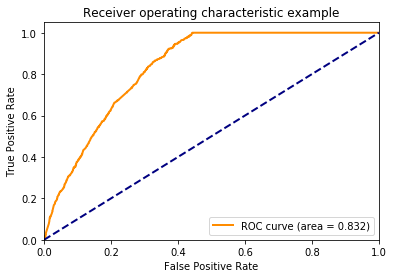

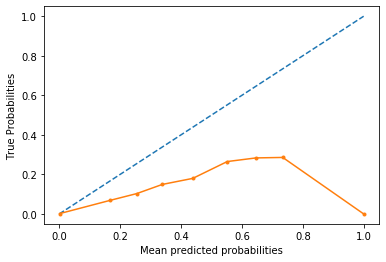

threshold=0.03, num clicks: predicted=631, actual=631


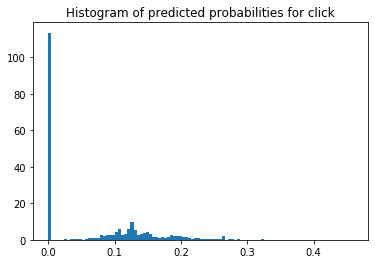

In [145]:
rf_pipe = make_rf_pipe_line(calibration = 'isotonic', class_weight = 'balanced')
print (rf_pipe)
evaulate_pipeline(rf_pipe, X_val, y_val)

# Cat Boost Model

In [146]:
def make_catboost_pipe_line(train_pool, validation_pool, class_weight = None, target_encoder = False):
    model = CatBoostClassifier(iterations=500,
                               learning_rate=None,
                              cat_features=cat_features,
                               depth=5,
                               custom_loss = ['AUC', 'Logloss','BrierScore', 'Precision', 'Recall'],
                               early_stopping_rounds = 20,
                               auto_class_weights = class_weight,
                               subsample= 0.5,
                               verbose=30)
    model.fit(train_pool, eval_set=validation_pool, plot=True)
    return model


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.12645
0:	learn: 0.4355756	test: 0.4325244	best: 0.4325244 (0)	total: 161ms	remaining: 1m 20s
30:	learn: 0.1940269	test: 0.1823650	best: 0.1823650 (30)	total: 3.17s	remaining: 48s
60:	learn: 0.1926246	test: 0.1814941	best: 0.1814941 (60)	total: 6.97s	remaining: 50.1s
90:	learn: 0.1919406	test: 0.1812945	best: 0.1812945 (90)	total: 10.2s	remaining: 45.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.1812480668
bestIteration = 94

Shrink model to first 95 iterations.


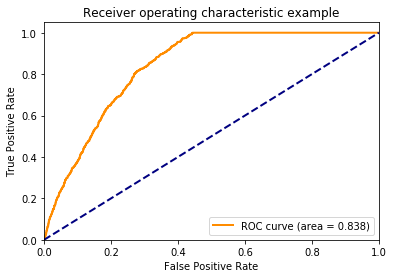

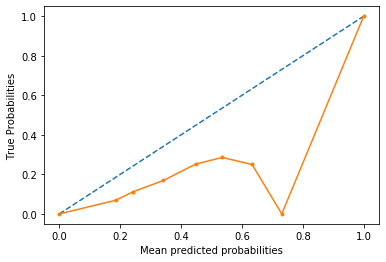

threshold=0.08, num clicks: predicted=631, actual=631


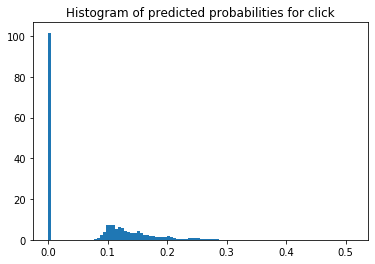

In [147]:
validation_pool = Pool(data = X_val, label = y_val, cat_features=cat_features)
train_pool = Pool(data = X_train, label = y_train, cat_features=cat_features)

catboost_pipe = make_catboost_pipe_line(train_pool, validation_pool, target_encoder = False, class_weight = None)
print (catboost_pipe)
evaulate_pipeline(catboost_pipe, X_val, y_val)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.12645
0:	learn: 0.5656084	test: 0.5616423	best: 0.5616423 (0)	total: 148ms	remaining: 1m 13s
30:	learn: 0.4372298	test: 0.4367696	best: 0.4367696 (30)	total: 3.42s	remaining: 51.8s
60:	learn: 0.4343785	test: 0.4353947	best: 0.4353634 (54)	total: 6.42s	remaining: 46.2s
90:	learn: 0.4320403	test: 0.4342685	best: 0.4342685 (90)	total: 10.5s	remaining: 47.4s
120:	learn: 0.4286092	test: 0.4334623	best: 0.4334520 (116)	total: 15.3s	remaining: 47.8s
150:	learn: 0.4256143	test: 0.4332567	best: 0.4331235 (140)	total: 19.5s	remaining: 45.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4331234755
bestIteration = 140

Shrink model to first 141 iterations.


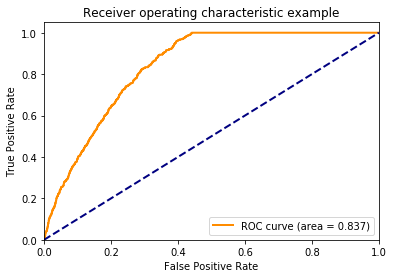

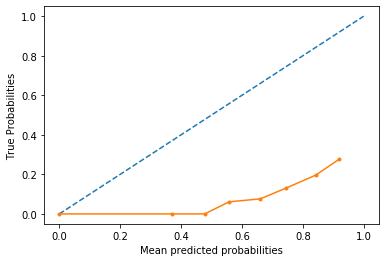

threshold=0.46, num clicks: predicted=631, actual=631


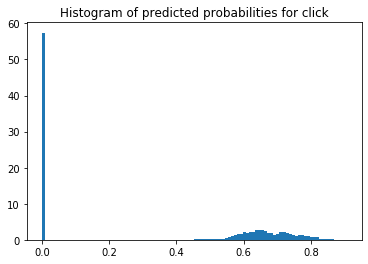

In [148]:
catboost_pipe_bl = make_catboost_pipe_line(train_pool, validation_pool, target_encoder = False, class_weight = 'Balanced')
print (catboost_pipe_bl)
evaulate_pipeline(catboost_pipe_bl, X_val, y_val)

# Shap Values

In [181]:
model = catboost_pipe_bl


# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
shap.initjs()


Shap Values (Shapely Additive exPlanations is a model Agnostic method for explaining model predictions
It is based on theory developed by Loid Shapley in the 1950's 

# Shap Summary Plot

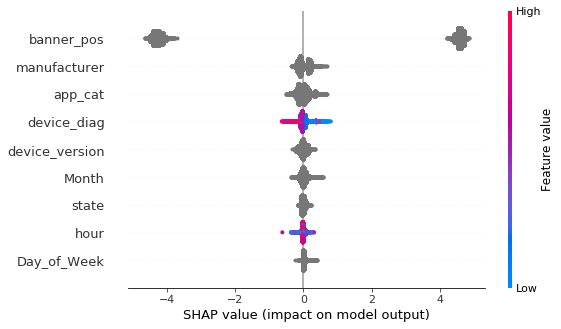

In [182]:

shap.summary_plot(shap_values[0])

In [221]:

def explain_simple(idx, X_train):
    data = X_train.iloc[[idx]]
    shap_values = explainer.shap_values( data)
    return (shap.force_plot(expected_value,shap_values , data, link='logit'))

# 3 random prediction explanations

In [225]:
explain_simple(18744, X_train)

In [226]:
explain_simple(71729, X_train)

In [227]:
explain_simple(52144, X_train)